# imports/setup

In [4]:
import datetime
import json
import pandas as pd
from collections import defaultdict
from typing import List, Dict, Any
import string
import jsonpickle
import numpy as np
import math
from datamodel import Listing, ConversionObservation
from round_1_new import Trader
from backtester import Backtester
import io

# backtester

# trader

In [5]:
class Product:
    RAINFOREST_RESIN = "RAINFOREST_RESIN"
    SQUID_INK = "SQUID_INK"


PARAMS = {
    Product.RAINFOREST_RESIN: {
        "fair_value": 10000,
        "take_width": 1,
        "clear_threshold": 30,
        "clear_width": 0,
        # for making
        "disregard_edge": 0,  # disregards orders for joining or pennying within this value from fair
        "join_edge": 1,  # joins orders within this edge
        "default_edge": 4,
        "soft_position_limit": 50,
    },
    # Product.SQUID_INK: {
    #     "take_width": 1,
    #     "clear_width": 0,
    #     "clear_threshold": 20,
    #     "prevent_adverse": True,
    #     "adverse_volume": 15,
    #     "reversion_beta": -0.178,
    #     "disregard_edge": 1,
    #     "join_edge": 0,
    #     "default_edge": 1,
    #     "soft_position_limit": 20,
    # },
}

# backtest run

In [6]:
def _process_data_(file):
    with open(file, 'r') as file:
        log_content = file.read()
    sections = log_content.split('Sandbox logs:')[1].split('Activities log:')
    sandbox_log =  sections[0].strip()
    activities_log = sections[1].split('Trade History:')[0]
    # sandbox_log_list = [json.loads(line) for line in sandbox_log.split('\n')]
    trade_history =  json.loads(sections[1].split('Trade History:')[1])
    # sandbox_log_df = pd.DataFrame(sandbox_log_list)
    market_data_df = pd.read_csv(io.StringIO(activities_log), sep=";", header=0)
    trade_history_df = pd.json_normalize(trade_history)
    # print(sections[1])
    return market_data_df, trade_history_df

### setup

In [7]:
def calculate_SQUID_INK_fair(order_depth):
    # assumes order_depth has orders in it 
    best_ask = min(order_depth.sell_orders.keys())
    best_bid = max(order_depth.buy_orders.keys())
    filtered_ask = [price for price in order_depth.sell_orders.keys() if abs(order_depth.sell_orders[price]) >= 15]
    filtered_bid = [price for price in order_depth.buy_orders.keys() if abs(order_depth.buy_orders[price]) >= 15]
    mm_ask = min(filtered_ask) if len(filtered_ask) > 0 else best_ask
    mm_bid = max(filtered_bid) if len(filtered_bid) > 0 else best_bid

    mmmid_price = (mm_ask + mm_bid) / 2
    return mmmid_price
    
def calculate_KELP_fair(order_depth):
    # assumes order_depth has orders in it 
    best_ask = min(order_depth.sell_orders.keys())
    best_bid = max(order_depth.buy_orders.keys())
    filtered_ask = [price for price in order_depth.sell_orders.keys() if abs(order_depth.sell_orders[price]) >= 15]
    filtered_bid = [price for price in order_depth.buy_orders.keys() if abs(order_depth.buy_orders[price]) >= 15]
    mm_ask = min(filtered_ask) if len(filtered_ask) > 0 else best_ask
    mm_bid = max(filtered_bid) if len(filtered_bid) > 0 else best_bid

    mmmid_price = (mm_ask + mm_bid) / 2
    return mmmid_price
    
    
def calculate_RAINFOREST_RESIN_fair(order_depth):
    return 10000

In [8]:
listings = {
    'RAINFOREST_RESIN': Listing(symbol='RAINFOREST_RESIN', product='RAINFOREST_RESIN', denomination='SEASHELLS'),
    'SQUID_INK': Listing(symbol='SQUID_INK', product='SQUID_INK', denomination='SEASHELLS'),
    'KELP': Listing(symbol='KELP', product='KELP', denomination='SEASHELLS')
}

position_limit = {
    'RAINFOREST_RESIN': 50,
    'SQUID_INK': 50,
    'KELP': 50
}

fair_calculations = {
    "RAINFOREST_RESIN": calculate_RAINFOREST_RESIN_fair,
    "SQUID_INK": calculate_SQUID_INK_fair,
    "KELP": calculate_KELP_fair
}

Backtest with the trades with null strategy

In [24]:
# auto reload Trader
import round_1_new
from importlib import reload
reload(round_1_new)
from round_1_new import Trader

market_data, trade_history = _process_data_('./logs/round1_0.log')
trader = Trader()
backtester = Backtester(trader, listings, position_limit, fair_calculations, market_data, trade_history, './backtestruns/round1_0.txt')
backtester.run()
print(backtester.pnl)

{'RAINFOREST_RESIN': 1546, 'SQUID_INK': 0.0, 'KELP': 0.0}


Visualize trades

In [48]:
market_data, trade_history = _process_data_('./logs/resin_20thre_1width.log')
# market_data, trade_history = _process_data_('./logs/resin_49threshold.log')
# market_data, trade_history = _process_data_('./logs/resin_30_clearthreshold.log')

In [49]:
my_trades = trade_history[(trade_history['buyer'] == 'SUBMISSION') | (trade_history['seller'] == 'SUBMISSION')]

In [50]:
my_trades.loc[:, 'side'] = my_trades.apply(lambda x:  1 if x['buyer'] == 'SUBMISSION' else -1, axis=1)
my_trades.loc[:, 'position'] = (my_trades['side'] * my_trades['quantity']).cumsum()

C:\Users\danny\AppData\Local\Temp\ipykernel_9208\2027638977.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_trades.loc[:, 'side'] = my_trades.apply(lambda x:  1 if x['buyer'] == 'SUBMISSION' else -1, axis=1)
C:\Users\danny\AppData\Local\Temp\ipykernel_9208\2027638977.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_trades.loc[:, 'position'] = (my_trades['side'] * my_trades['quantity']).cumsum()


<Axes: >

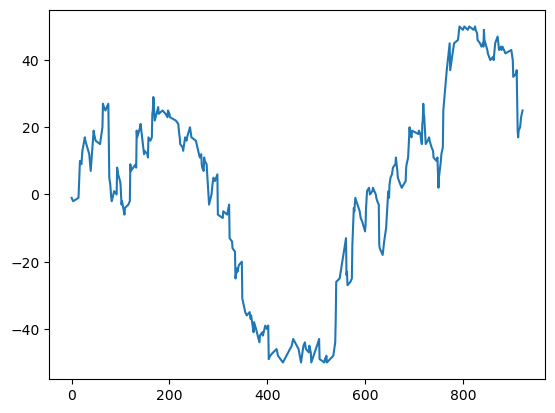

In [51]:
my_trades['position'].plot()

In [13]:
# with fair prediction
day = 0
market_data = pd.read_csv(f"./round-1-island-data-bottle/prices_round_1_day_{day}.csv", sep=";", header=0)
trade_history = pd.read_csv(f"./round-1-island-data-bottle/trades_round_1_day_{day}.csv", sep=";", header=0)

trader = Trader()
backtester = Backtester(trader, listings, position_limit, fair_calculations, market_data, trade_history, "./backtestruns/round1_day0_sim.txt")
backtester.run()
print(backtester.pnl)


{'RAINFOREST_RESIN': 15414, 'SQUID_INK': 0.0, 'KELP': 0.0}


In [ ]:
day = 0
market_data = pd.read_csv(f"./round-1-island-data-bottle/prices_round_1_day_{day}.csv", sep=";", header=0)
trade_history = pd.read_csv(f"./round-1-island-data-bottle/trades_round_1_day_{day}.csv", sep=";", header=0)

trader = Trader()
backtester = Backtester(trader, listings, position_limit, fair_calculations, market_data, trade_history, "trade_history_sim.log")
backtester.run()
print(backtester.pnl)

AttributeError: 'str' object has no attribute 'sort_values'

# backtest gridsearch

In [ ]:
import itertools

def generate_param_combinations(param_grid):
    param_names = param_grid.keys()
    param_values = param_grid.values()
    combinations = list(itertools.product(*param_values))
    return [dict(zip(param_names, combination)) for combination in combinations]

In [ ]:
import os
from tqdm import tqdm

def run_backtests(trader, listings, position_limit, fair_calcs, market_data, trade_history, backtest_dir, param_grid, symbol):
    if not os.path.exists(backtest_dir):
        os.makedirs(backtest_dir)

    param_combinations = generate_param_combinations(param_grid[symbol])

    results = []
    for params in tqdm(param_combinations, desc=f"Running backtests for {symbol}", unit="backtest"):
        trader.params = {symbol: params}
        backtester = Backtester(trader, listings, position_limit, fair_calcs, market_data, trade_history)
        backtester.run()

        param_str = "-".join([f"{key}={value}" for key, value in params.items()])
        log_filename = f"{backtest_dir}/{symbol}_{param_str}.log"
        backtester._log_trades(log_filename)

        results.append((params, backtester.pnl[symbol]))

    return results

### setup

In [ ]:
listings = {
    'RAINFOREST_RESIN': Listing(symbol='RAINFOREST_RESIN', product='RAINFOREST_RESIN', denomination='SEASHELLS'),
    'SQUID_INK': Listing(symbol='SQUID_INK', product='SQUID_INK', denomination='SEASHELLS'),
    'KELP': Listing(symbol='KELP', product='KELP', denomination='SEASHELLS')
}

position_limit = {
    'RAINFOREST_RESIN': 50,
    'SQUID_INK': 50,
    'KELP': 50
}

fair_calculations = {
    "RAINFOREST_RESIN": calculate_RAINFOREST_RESIN_fair,
    "SQUID_INK": calculate_SQUID_INK_fair,
    "KELP": calculate_KELP_fair
}

In [ ]:
day = 0
market_data = pd.read_csv(f"./round-1-island-data-bottle/prices_round_1_day_{day}.csv", sep=";", header=0)
trade_history = pd.read_csv(f"./round-1-island-data-bottle/trades_round_1_day_{day}_nn.csv", sep=";", header=0)



### run

In [ ]:
backtest_dir = "backtestruns"

param_grid = {
    Product.RAINFOREST_RESIN: {
        "fair_value": [10000],
        "take_width": [1],
        "clear_width": [0.5],
        "volume_limit": [0],
        # for making
        "disregard_edge": [1],  # disregards orders for joining or pennying within this value from fair
        "join_edge": [2],# joins orders within this edge 
        "default_edge": [4]
    },
    Product.SQUID_INK: {
        "take_width": [1],
        "clear_width": [0, -0.25],
        "prevent_adverse": [True],
        "adverse_volume": [15],
        "reversion_beta": [-0.229],
        # for making
        "disregard_edge": [1],
        "join_edge": [3],
        "default_edge": [5],
    },
}



trader = Trader()

resin_results = run_backtests(trader, listings, position_limit, fair_calculations, market_data, trade_history, backtest_dir, param_grid, "RAINFOREST_RESIN")
print("RAINFOREST_RESIN results:")
for params, pnl in resin_results: 
    print(params)
    print(f"pnl: {pnl}")
    print("="*80)

SQUID_INK_results = run_backtests(trader, listings, position_limit, fair_calculations, market_data, trade_history, backtest_dir, param_grid, "SQUID_INK")
print("SQUID_INK results:")
for params, pnl in SQUID_INK_results:
    print(params)
    print(f"pnl: {pnl}")
    print("="*80)

## analyze

In [ ]:

def analyze_log_files(backtest_dir):
    log_files = [f for f in os.listdir(backtest_dir) if f.endswith('.log')]
    
    results = []
    for log_file in log_files:
        file_path = os.path.join(backtest_dir, log_file)
        
        # Extract symbol and parameters from the file name
        file_name = os.path.splitext(log_file)[0]
        print(file_name)
        symbol, params_str = file_name.split('-', 1)
        params = dict(param.split('=') for param in params_str.split('-'))
        
        # Read the contents of the log file
        with open(file_path, 'r') as file:
            log_content = file.read()
        
        # Store the symbol, parameters, and log content in the results
        results.append({
            'symbol': symbol,
            'params': params,
            'log_content': log_content
        })
    
    return results

# Analyze the log files
log_analysis_results = analyze_log_files(backtest_dir)

# Print the results
for result in log_analysis_results:
    print(f"Symbol: {result['symbol']}")
    print(f"Parameters: {result['params']}")
#     print(f"Log Content:\n{result['log_content']}\n")